In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot  as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/housedata/output.csv
/kaggle/input/housedata/data.csv
/kaggle/input/housedata/data.dat


In [2]:
# splitting the data

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Importing the models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# Importing the metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

import warnings

# Filter out a specific warning by category
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Importing dataset

df = pd.read_csv("/kaggle/input/housedata/data.csv")
df.head(4)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA


In [4]:
# Checking the shape of dataset

df.shape

(4600, 18)

In [5]:
# Looking at the datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [6]:
# Checking for NUll values in the dataset

df.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

In [7]:
# Checking for duplicate values in the data

df.duplicated().sum()

0

In [8]:
# Number of unique values in all columns

df.nunique()

date               70
price            1741
bedrooms           10
bathrooms          26
sqft_living       566
sqft_lot         3113
floors              6
waterfront          2
view                5
condition           5
sqft_above        511
sqft_basement     207
yr_built          115
yr_renovated       60
street           4525
city               44
statezip           77
country             1
dtype: int64

In [9]:
# Deleting unwanted columns in model building

del df["street"]
del df["city"]
del df["country"]
del df["date"]  

In [10]:
# Preparing the Statezip column data into more useful data

lis = []
for i in df["statezip"]:
    lis.append(i[2:])
    
arr = np.array(lis,dtype=np.int64)
df["statezip"] = arr

In [11]:
df.drop(np.where(df["price"]==0)[0],axis=0,inplace=True)

In [12]:
# Looking at the statistics of data 

df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,statezip
count,4.551000e+03,4551.000000,4551.000000,4551.000000,4.551000e+03,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000
mean,5.579059e+05,3.394639,2.155021,2132.372226,1.483528e+04,1.512195,0.006592,0.234674,3.449352,1822.221710,310.150516,1970.795649,808.564052,98079.397056
std,5.639299e+05,0.904595,0.776351,955.949708,3.596408e+04,0.538531,0.080932,0.765373,0.675160,854.452888,461.987629,29.760073,979.421487,53.048784
min,7.800000e+03,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000
25%,3.262643e+05,3.000000,1.750000,1460.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000
50%,4.650000e+05,3.000000,2.250000,1970.000000,7.680000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000,98072.000000
75%,6.575000e+05,4.000000,2.500000,2610.000000,1.097800e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,600.000000,1997.000000,1999.000000,98117.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000,98354.000000


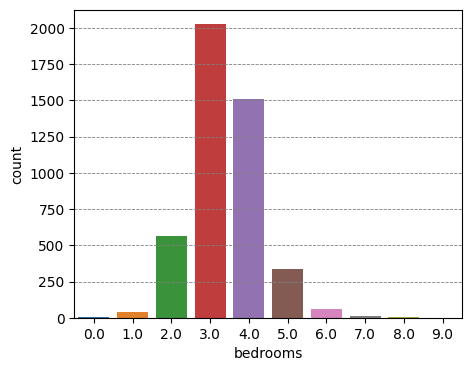

In [13]:
# Univariate analysis
plt.figure(figsize=(5,4))
sns.countplot(data = df,x = "bedrooms")
plt.grid(axis="y",color="grey",linestyle="--",linewidth=0.6)
plt.style.use("ggplot")
plt.show()

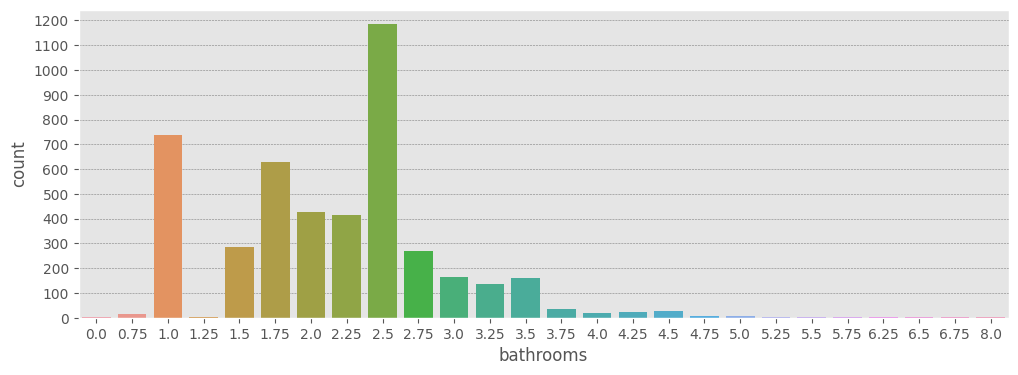

In [14]:
plt.figure(figsize=(12,4))
sns.countplot(data = df,x = "bathrooms")
plt.grid(axis="y",color="grey",linestyle="--",linewidth=0.4)
plt.yticks(range(0,1300,100))
plt.style.use("ggplot")
plt.show()

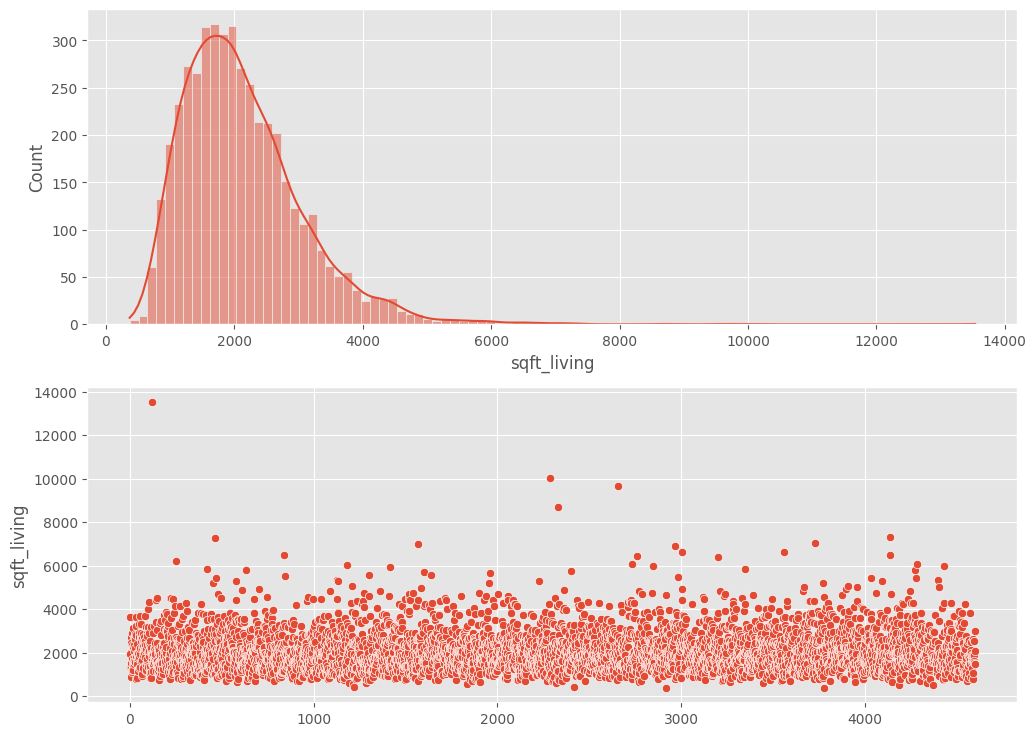

In [15]:
fig,axs = plt.subplots(2,1,figsize=(12,9))
plt.subplot(2,1,1)
sns.histplot(data=df,x="sqft_living",kde=True)
plt.ticklabel_format(style='plain', axis='x')
plt.style.use("ggplot")

plt.subplot(2,1,2)
sns.scatterplot(data=df,x=df.index,y="sqft_living")
plt.ticklabel_format(style='plain', axis='y')
plt.style.use("ggplot")
plt.show()

From above graph it is evident that in this column data is skewed. 

In [16]:
# Removing skewness from data

print("Before transformation skew : ",df["sqft_living"].skew())
df["sqft_living"] = np.log(df["sqft_living"])
print("After transformation skew : ",df["sqft_living"].skew())

Before transformation skew :  1.7188875411513491
After transformation skew :  -0.05370929015223324


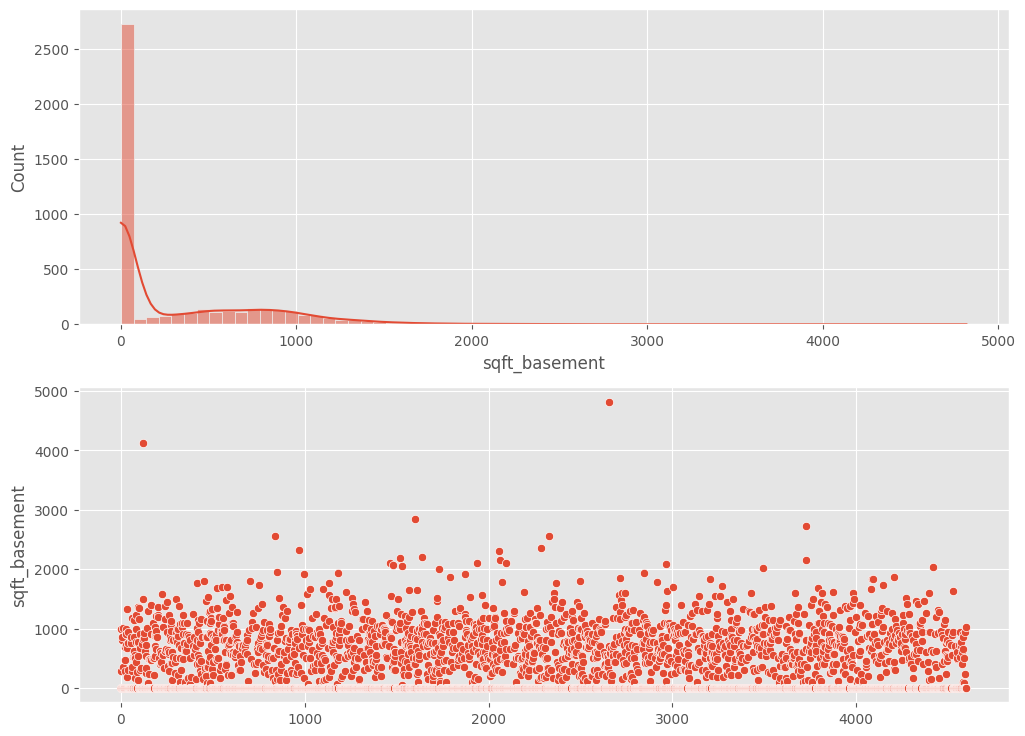

In [17]:
fig,axs = plt.subplots(2,1,figsize=(12,9))
plt.subplot(2,1,1)
sns.histplot(data=df,x="sqft_basement",kde=True)
plt.ticklabel_format(style='plain', axis='x')
plt.style.use("ggplot")

plt.subplot(2,1,2)
sns.scatterplot(data=df,x=df.index,y="sqft_basement")
plt.ticklabel_format(style='plain', axis='y')
plt.style.use("ggplot")
plt.show()

In [18]:
# Removing the skeness from data

print("Before transformation skew : ",df["sqft_basement"].skew())
df["sqft_basement"] = np.cbrt(df["sqft_basement"])
print("After transformation skew : ",df["sqft_basement"].skew())

Before transformation skew :  1.6550756371892148
After transformation skew :  0.5650940779006433


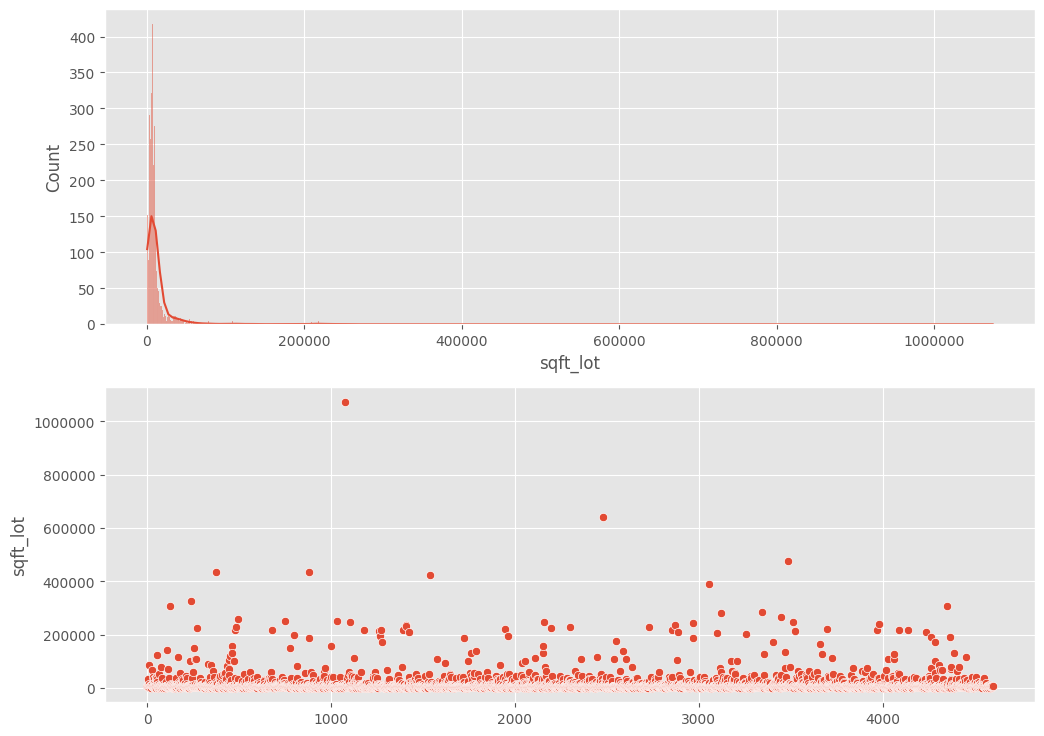

In [19]:
fig,axs = plt.subplots(2,1,figsize=(12,9))
plt.subplot(2,1,1)
sns.histplot(data=df,x="sqft_lot",kde=True)
plt.ticklabel_format(style='plain', axis='x')
plt.style.use("ggplot")

plt.subplot(2,1,2)
sns.scatterplot(data=df,x=df.index,y="sqft_lot")
plt.ticklabel_format(style='plain', axis='y')
plt.style.use("ggplot")
plt.show()

In [20]:
# Removing the skewness from data

print("Before transformation skew : ",df["sqft_lot"].skew())
df["sqft_lot"] = np.log(df["sqft_lot"])
print("After transformation skew : ",df["sqft_lot"].skew())

Before transformation skew :  11.329014386009023
After transformation skew :  0.8412624258021195


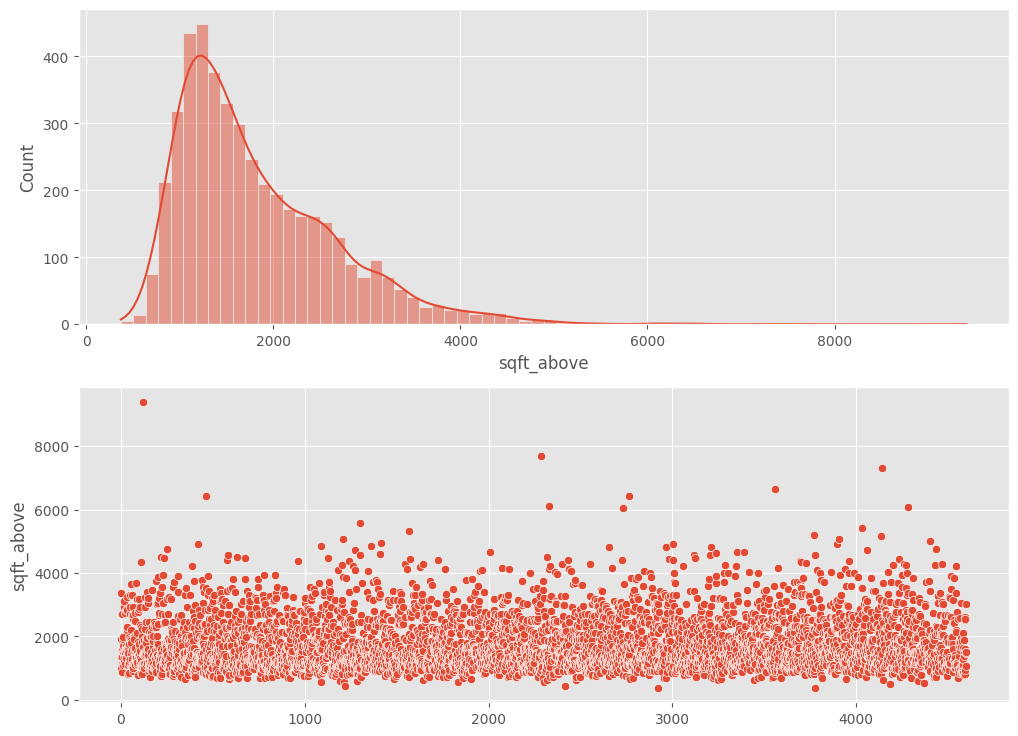

In [21]:
fig,axs = plt.subplots(2,1,figsize=(12,9))
plt.subplot(2,1,1)
sns.histplot(data=df,x="sqft_above",kde=True)
plt.ticklabel_format(style='plain', axis='x')
plt.style.use("ggplot")

plt.subplot(2,1,2)
sns.scatterplot(data=df,x=df.index,y="sqft_above")
plt.ticklabel_format(style='plain', axis='y')
plt.style.use("ggplot")
plt.show()

In [22]:
# Removing the skewness from data

print("Before transformation skew : ",df["sqft_above"].skew())
df["sqft_above"] = np.log(df["sqft_above"])
print("After transformation skew : ",df["sqft_above"].skew())

Before transformation skew :  1.4539329178421054
After transformation skew :  0.23924533231027634


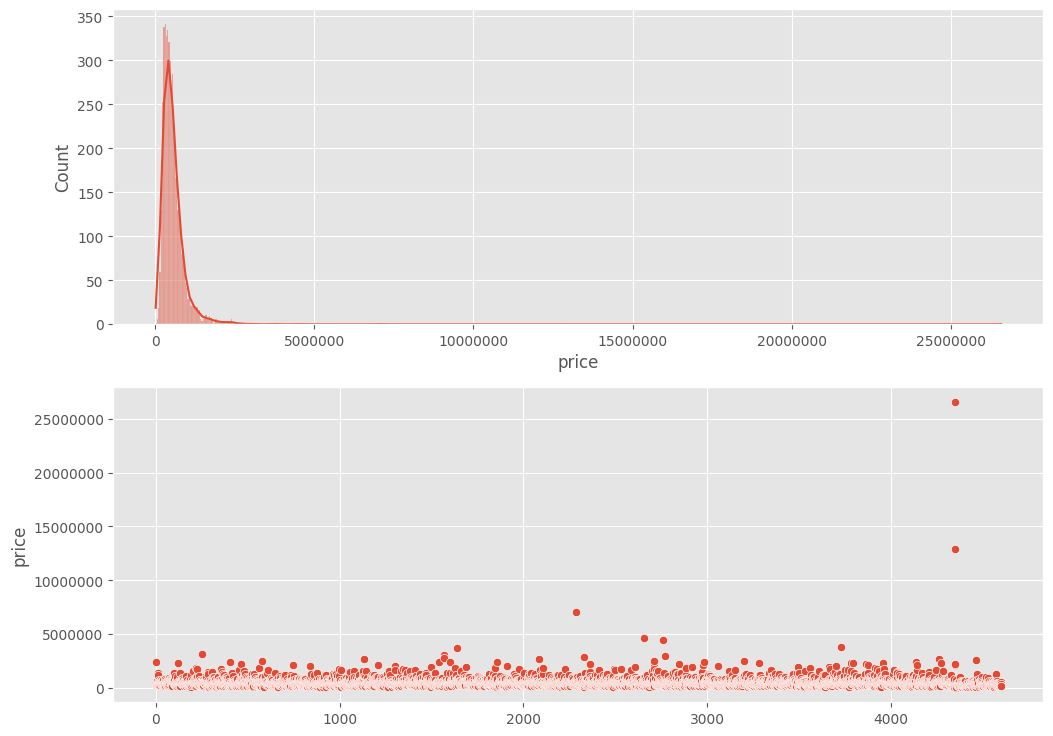

In [23]:
fig,axs = plt.subplots(2,1,figsize=(12,9))
plt.subplot(2,1,1)
sns.histplot(data=df,x="price",kde=True)
plt.ticklabel_format(style='plain', axis='x')
plt.style.use("ggplot")

plt.subplot(2,1,2)
sns.scatterplot(data=df,x=df.index,y="price")
plt.ticklabel_format(style='plain', axis='y')
plt.style.use("ggplot")
plt.show()

In [24]:
print("Before transformation skew : ",df["price"].skew())
df["price"] = np.log(df["price"])
print("After transformation skew : ",df["price"].skew())

Before transformation skew :  25.023817262008482
After transformation skew :  0.3299813838090415


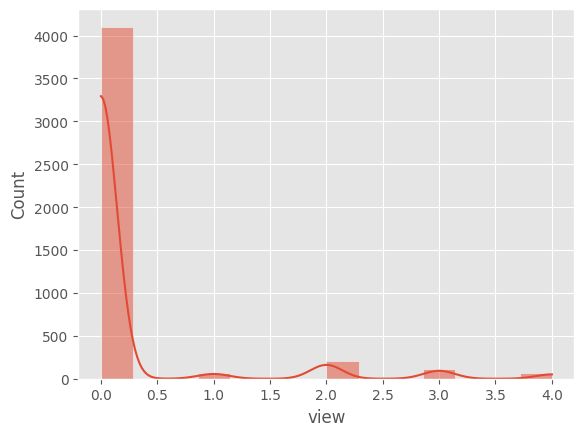

In [25]:

sns.histplot(data=df,x="view",kde=True)
plt.style.use("ggplot")


In [26]:
# Removing the skewness

print("Before transformation skew : ",df["view"].skew())
df["view"] = np.cbrt(df["view"])
print("After transformation skew : ",df["view"].skew())

Before transformation skew :  3.3733978634952058
After transformation skew :  2.7925334595507962


Median value of house with respect to number of bedrooms : 
 bedrooms
0.0    13.990393
1.0    12.524526
2.0    12.821258
3.0    12.959844
4.0    13.262125
5.0    13.303017
6.0    13.415033
7.0    13.462471
8.0    13.615122
9.0    13.304683
Name: price, dtype: float64


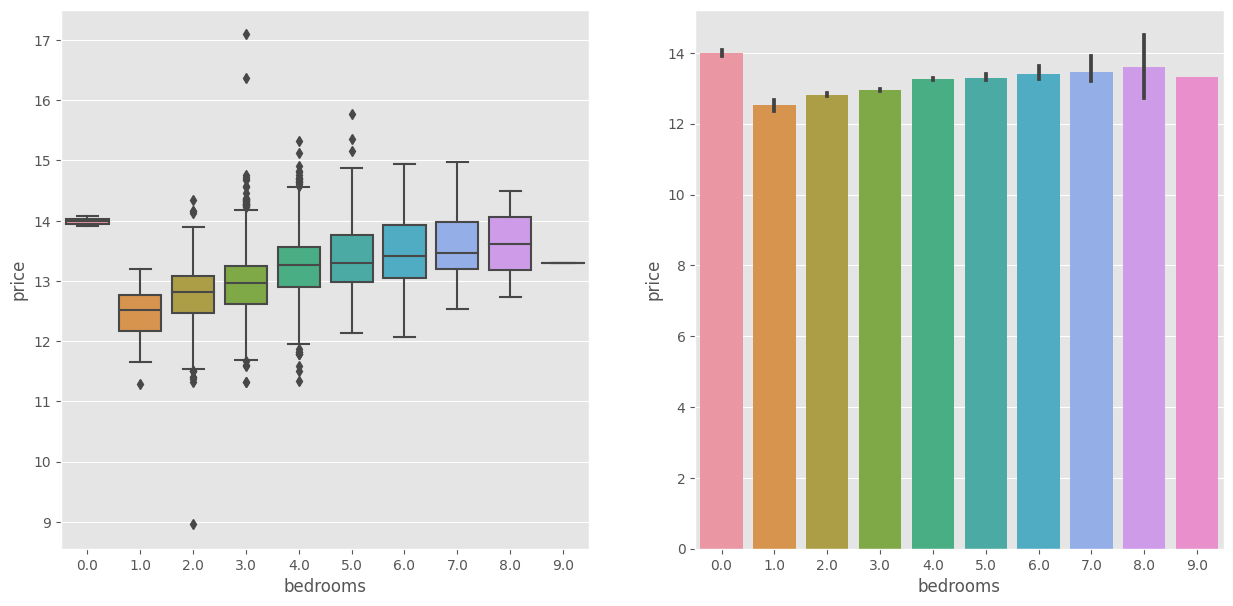

In [27]:
fig,axs = plt.subplots(1,2,figsize=(15,7))
plt.subplot(1,2,1)
sns.boxplot(data=df,y="price",x="bedrooms")
plt.ticklabel_format(style='plain', axis='y')
plt.style.use("ggplot")

print("Median value of house with respect to number of bedrooms : \n",df.groupby("bedrooms")["price"].median())

plt.subplot(1,2,2)
sns.barplot(data=df,y="price",x="bedrooms", estimator=np.median)
plt.ticklabel_format(style='plain', axis='y')

plt.show()

Median value of house with respect to number of floors : 
 floors
1.0    12.886641
1.5    13.191889
2.0    13.230321
2.5    13.630987
3.0    13.081541
3.5    13.574094
Name: price, dtype: float64


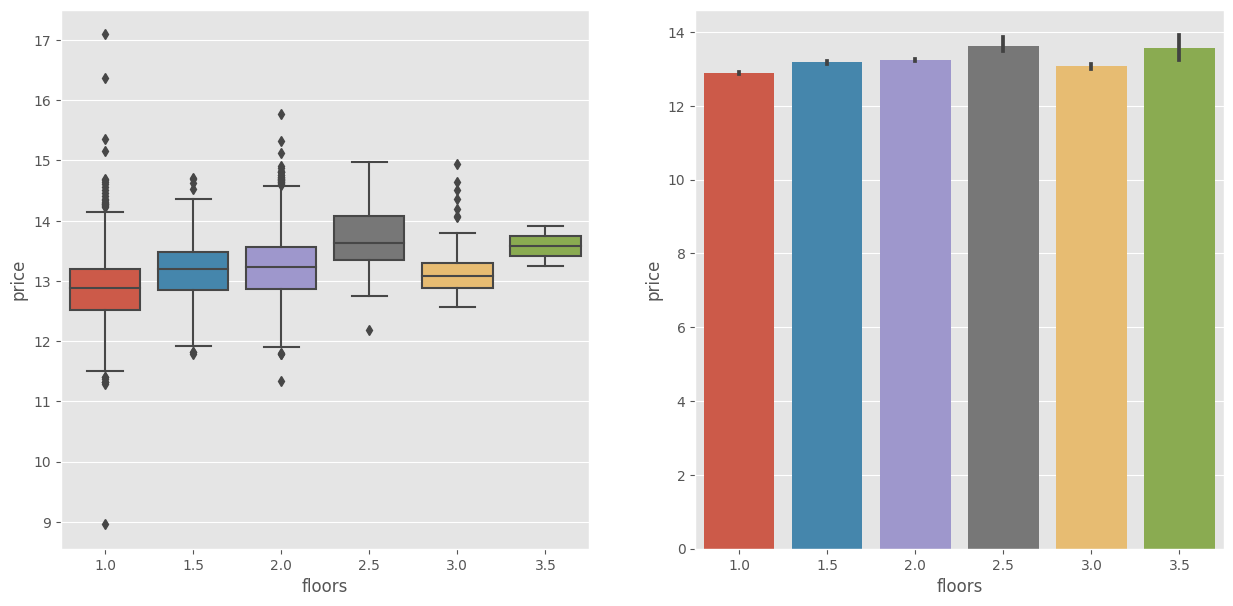

In [28]:
fig,axs = plt.subplots(1,2,figsize=(15,7))
plt.subplot(1,2,1)
sns.boxplot(data=df,y="price",x="floors")
plt.ticklabel_format(style='plain', axis='y')
plt.style.use("ggplot")

print("Median value of house with respect to number of floors : \n",df.groupby("floors")["price"].median())
plt.subplot(1,2,2)
sns.barplot(data=df,y="price",x="floors",estimator=np.median)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Median value of house with respect to number of waterfront : 
 waterfront
0    13.047640
1    13.882885
Name: price, dtype: float64


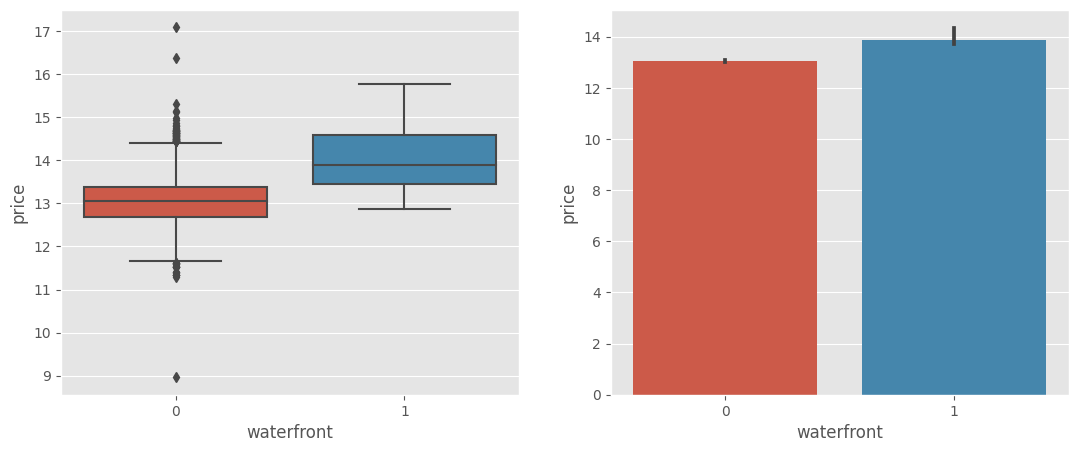

In [29]:
fig,axs = plt.subplots(1,2,figsize=(13,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,y="price",x="waterfront")
plt.ticklabel_format(style='plain', axis='y')
plt.style.use("ggplot")

print("Median value of house with respect to number of waterfront : \n",df.groupby("waterfront")["price"].median())
plt.subplot(1,2,2)
sns.barplot(data=df,y="price",x="waterfront",estimator=np.median)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Median value of house with respect to number of view : 
 view
0.000000    13.005830
1.000000    13.485617
1.259921    13.407467
1.442250    13.710150
1.587401    13.954403
Name: price, dtype: float64


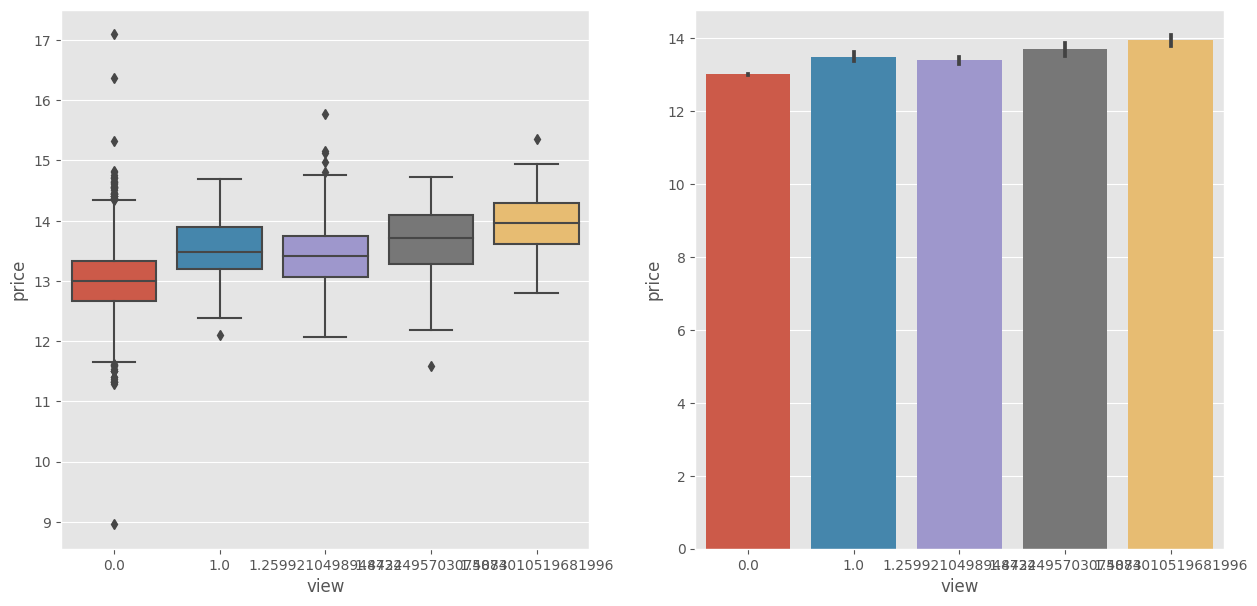

In [30]:
fig,axs = plt.subplots(1,2,figsize=(15,7))
plt.subplot(1,2,1)
sns.boxplot(data=df,y="price",x="view")
plt.ticklabel_format(style='plain', axis='y')
plt.style.use("ggplot")

print("Median value of house with respect to number of view : \n",df.groupby("view")["price"].median())

plt.subplot(1,2,2)
sns.barplot(data=df,y="price",x="view", estimator=np.median)
plt.ticklabel_format(style='plain', axis='y')

plt.show()

Median value of house with respect to number of condition : 
 condition
1    12.628336
2    12.429216
3    13.051834
4    12.994530
5    13.232114
Name: price, dtype: float64


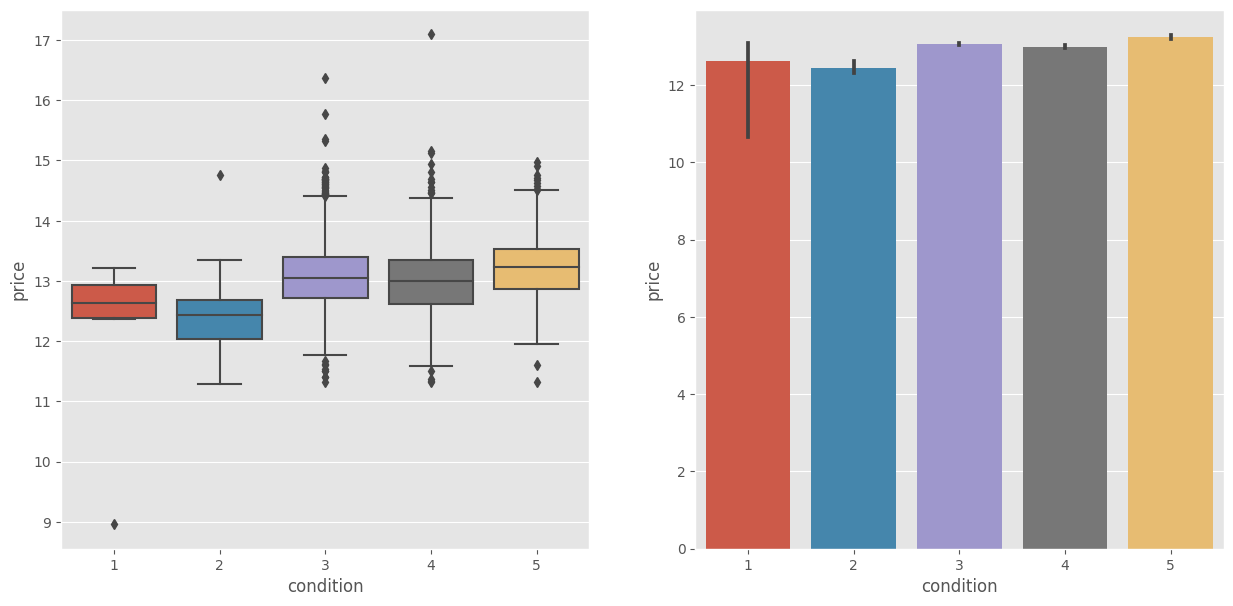

In [31]:
fig,axs = plt.subplots(1,2,figsize=(15,7))
plt.subplot(1,2,1)
sns.boxplot(data=df,y="price",x="condition")
plt.ticklabel_format(style='plain', axis='y')
plt.style.use("ggplot")

print("Median value of house with respect to number of condition : \n",df.groupby("condition")["price"].median())

plt.subplot(1,2,2)
sns.barplot(data=df,y="price",x="condition", estimator=np.median)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

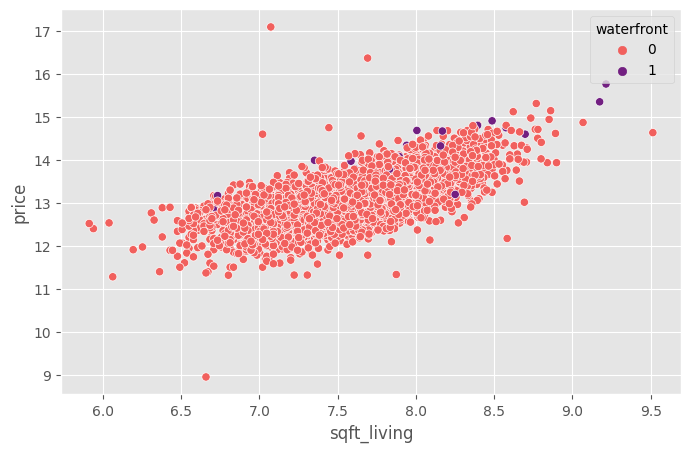

In [32]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df,y="price",x="sqft_living",hue="waterfront",palette= 'magma_r')
plt.ticklabel_format(style='plain', axis='y')
plt.style.use("ggplot")
plt.show()

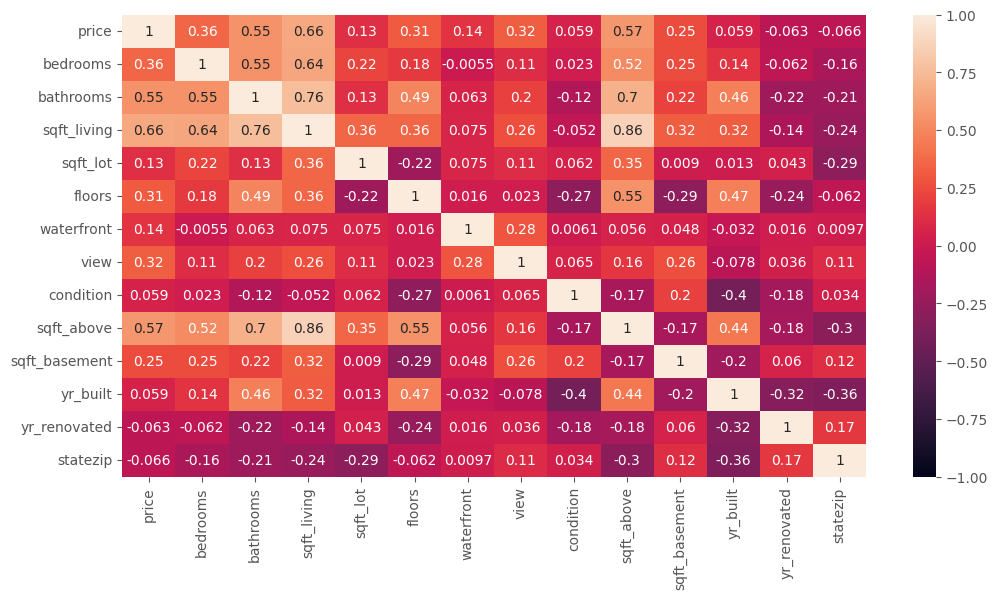

In [33]:
# Checking the correlation of features

plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=True,vmax=1,vmin=-1)
plt.show()

In [34]:
del df["sqft_above"]

In [35]:
# Splitting the data in target and Features

X = df.drop("price",axis=1,inplace=False)
Y = df.loc[:,"price"]

print("Shape of x : ",X.shape)
print("Shape of y : ",Y.shape)

Shape of x :  (4551, 12)
Shape of y :  (4551,)


In [36]:
# scalling the data

scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)

In [37]:
# Splitting the data in training and testing

Xtrain,Xtest,Ytrain,Ytest = train_test_split(Xscaled,Y,test_size=0.2,random_state=42)

In [38]:
# Building the model

gradient = GradientBoostingRegressor(random_state=42)
gradient.fit(Xtrain,Ytrain)

GradientBoostingRegressor(random_state=42)

In [39]:
Ypred = gradient.predict(Xtest)

In [40]:
# Calculating the metrics

print("mse : ",mean_squared_error(Ytest,Ypred))
print("rmse : ",np.sqrt(mean_squared_error(Ytest,Ypred)))
print("mae : ",mean_absolute_error(Ytest,Ypred))
print("train r2score : ",r2_score(Ytrain,gradient.predict(Xtrain)))
print("test r2score : ",r2_score(Ytest,Ypred))

mse :  0.09483376005552563
rmse :  0.3079509052682353
mae :  0.21516809555142846
train r2score :  0.7817068398863385
test r2score :  0.676252603336521


In [41]:
# Setting hyperparameters

parameter = {
                "learning_rate":[0.05,0.08,0.1,0.04],
                "n_estimators":[100,200,300,400],
                "min_samples_split":[4,6,8,9,11],
                "min_samples_leaf":[3,5,7,9],
                "max_depth":[5,7,9,11]
}

In [42]:
# Hyperparameter tuning

gradient = GradientBoostingRegressor()
random = RandomizedSearchCV(gradient,parameter,cv=5,random_state=42)
random.fit(Xtrain,Ytrain)
best_parameters = random.best_params_
best_score = random.best_score_
print(best_parameters)
print(best_score)

{'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 5, 'learning_rate': 0.08}
0.7550284250987516


In [43]:
Ypred = random.predict(Xtest)
print("mse : ",mean_squared_error(Ytest,Ypred))
print("rmse : ",np.sqrt(mean_squared_error(Ytest,Ypred)))
print("mae : ",mean_absolute_error(Ytest,Ypred))
print("test r2score : ",r2_score(Ytest,Ypred))

mse :  0.07476267396355026
rmse :  0.2734276393555528
mae :  0.17726477614801187
test r2score :  0.7447721038464765


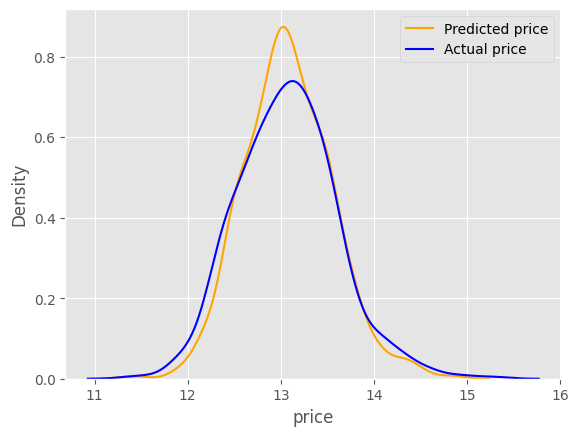

In [44]:
sns.kdeplot(x=Ypred,color="orange",label="Prdicted price")
sns.kdeplot(x=Ytest,color="blue",label="Actual price")
plt.legend(["Predicted price","Actual price"])
plt.show()